# UNET

<strong>Inspired by:</strong>
<ul>
    <li>https://www.kaggle.com/code/vikram12301/multiclass-semantic-segmentation-pytorch</li>
    <li>https://arxiv.org/pdf/1505.04597</li>
    <li>NVIDIA DLI Generative AI course </li>
</ul>


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop

import os
import re
from tqdm import tqdm

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
device = torch.device(device)
device

device(type='cpu')

## Data 

In [3]:
class KeyboardDataset(Dataset):
    def __init__(self, img_dir, transform = None):
        self.transform = transform
        self.dir = img_dir
        all_images = os.listdir(img_dir)
        self.images = [img for img in all_images if re.search("Image", img)]

    def __len__(self):
        return len(self.images)
    
    def _get_mask_for_image(self,img):
        return img.replace("Image", "Segmentation")
    
    def __getitem__(self, index):
        img_path = self.images[index]
        img =  Image.open(os.path.join(self.dir, img_path)).convert("RGB") 
        mask = Image.open(os.path.join(self.dir, self._get_mask_for_image(img_path)))
        if self.transform is not None:
            img, mask = self.transform(img), self.transform(mask)
        return img, mask

In [4]:
transforms = Compose(
    [
       CenterCrop(1080),
       ToTensor()
    ]
)

In [12]:
img_dir = os.path.join("..", "data_generation", "data", "final_renders")

In [13]:
def get_images(image_dir, transform = None, batch_size = 1, shuffle = True, pin_memory=False):
    dataset = KeyboardDataset(img_dir=image_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_loader, test_loader

### Testing loaders

In [14]:
train_loader, test_loader = get_images(img_dir, transforms, batch_size=4)

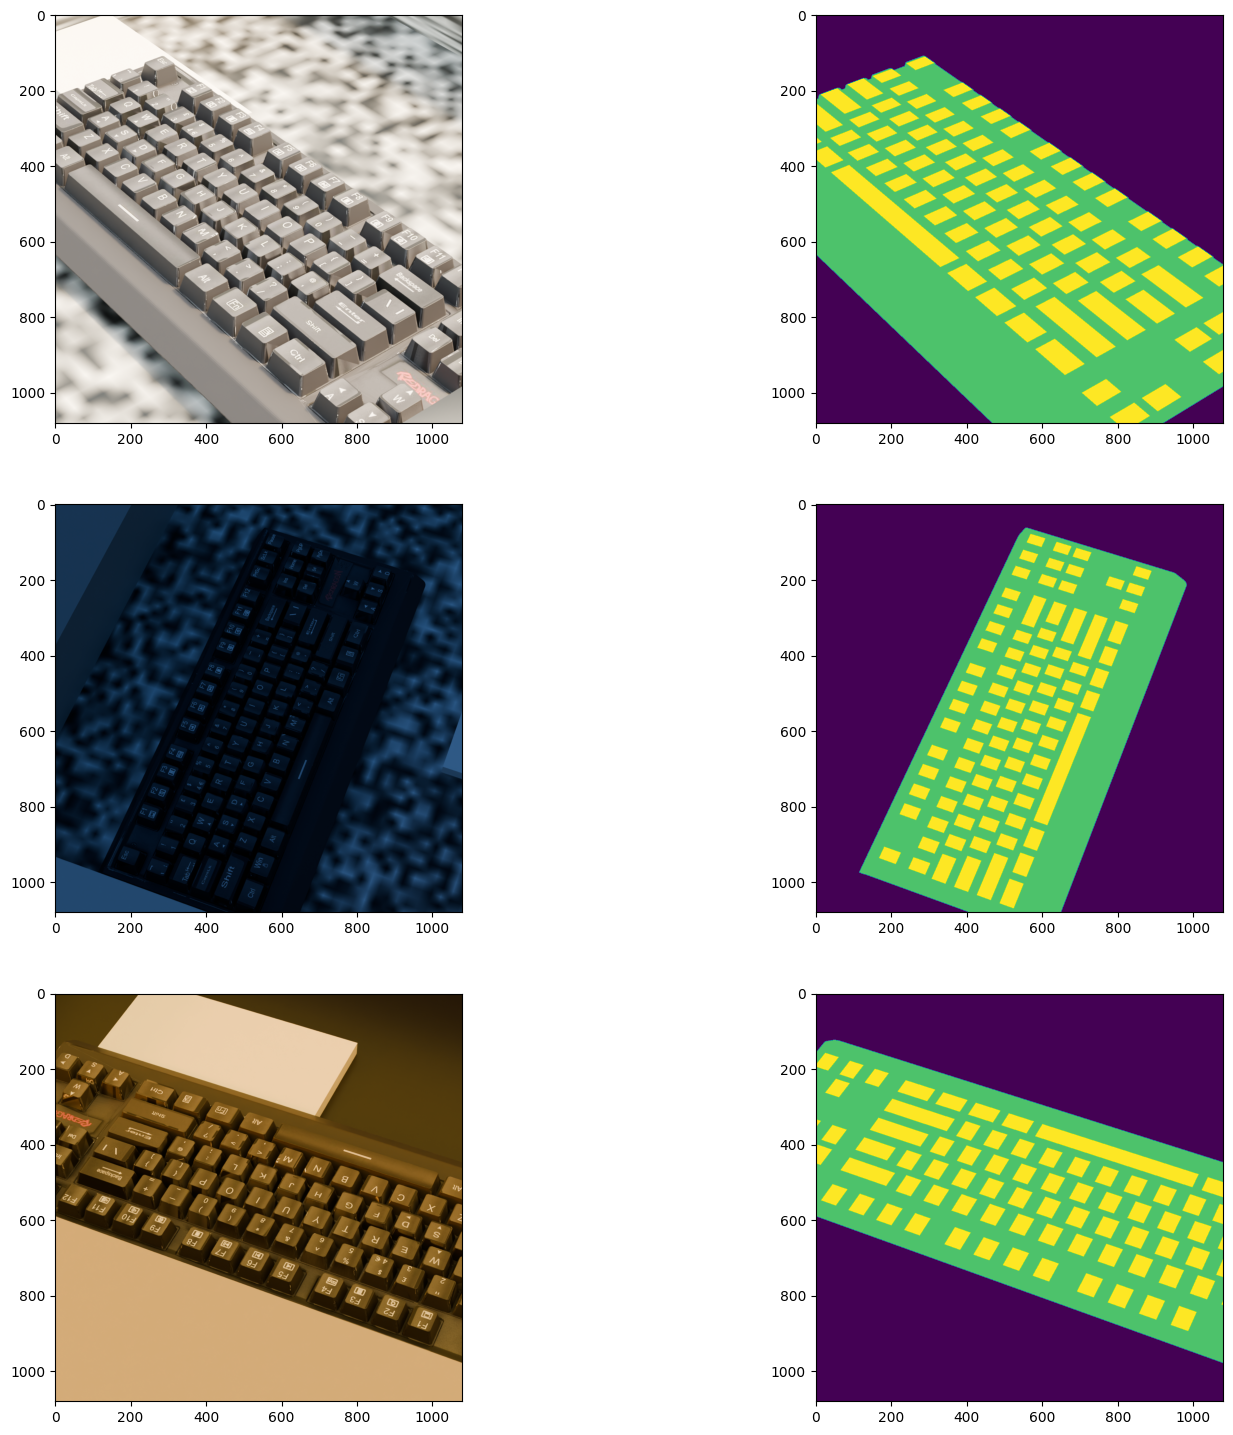

In [8]:
for img,mask in train_loader:
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(np.squeeze(mask1))
    ax[1][0].imshow(img2)
    ax[1][1].imshow(np.squeeze(mask2))
    ax[2][0].imshow(img3)
    ax[2][1].imshow(np.squeeze(mask3))
    break

## Model

In [15]:
class RELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch,3,1,1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            RELUConvBlock(in_ch, out_ch),
            RELUConvBlock(out_ch, out_ch)
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.model(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        layers = [
            RELUConvBlock(in_ch, out_ch),
            RELUConvBlock(out_ch, out_ch)
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.model(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, out_ch = 2, down_ch = [64,128,256,512]):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.down0 = DownBlock(3, down_ch[0])
        self.down1 = DownBlock(down_ch[0], down_ch[1])
        self.down2 = DownBlock(down_ch[1], down_ch[2])
        self.down3 = DownBlock(down_ch[2], down_ch[3])
 
        self.bottleneck = DownBlock(down_ch[3], 2*down_ch[3])

        self.up3 = UpBlock(2*down_ch[-1], down_ch[-1])
        self.up2 = UpBlock(down_ch[-1], down_ch[-2])
        self.up1 = UpBlock(down_ch[-2], down_ch[-3])
        self.up0 = UpBlock(down_ch[-3], down_ch[-4])

        self.connect_b_up3 = nn.ConvTranspose2d(2*down_ch[-1], down_ch[-1],kernel_size=2,stride=2)
        self.connect_up3_up2 = nn.ConvTranspose2d(down_ch[-1], down_ch[-2],kernel_size=2,stride=2)
        self.connect_up2_up1 = nn.ConvTranspose2d(down_ch[-2], down_ch[-3],kernel_size=2,stride=2)
        self.connect_up1_up0 = nn.ConvTranspose2d(down_ch[-3], down_ch[-4],kernel_size=2,stride=2)

        self.final_conv = nn.Conv2d(down_ch[0], out_ch, kernel_size=1)

    def _crop_to_match(self, tensor, target):
        _, _, h, w = target.shape
        return tensor[:, :, :h, :w]
    
    def forward(self, x):
        skip_connections = []
        x = self.down0(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.down3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)

        x = self.connect_b_up3(x)
        skip_connection = self._crop_to_match(skip_connections[3], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up3(x)
        x = self.connect_up3_up2(x)
        skip_connection = self._crop_to_match(skip_connections[2], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up2(x)
        x = self.connect_up2_up1(x)
        skip_connection = self._crop_to_match(skip_connections[1], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up1(x)
        x = self.connect_up1_up0(x)
        skip_connection = self._crop_to_match(skip_connections[0], x)
        x = torch.cat((skip_connection, x), dim=1)
        x = self.up0(x)

        x = self.final_conv(x)

        return x


## Training

In [17]:
model = UNet().to(device)
print("Mun params:", sum(p.numel() for p in model.parameters()))

Mun params: 31043586


In [18]:
LEARNING_RATE = 1e-4 #na potrzeby testy stały, ale może dodam go w postaci funcji epoki
num_epochs = 5

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.amp.GradScaler(('cpu'))

In [ ]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for batch_idx, (data, targets) in loop:
        data = data.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.long)

        with torch.amp.autocast(device_type='cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss = loss.item())

  0%|          | 0/2 [00:00<?, ?it/s]/home/mparadow/.conda/envs/keyboard_det/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
